# Tratamento dos dados


In [1]:
# @title Lendo a planilha

import numpy as np
import pandas as pd

# Carregar o arquivo
df = pd.read_csv("../gPROMS/simul_Performance.csv", skiprows=7)

df = df.drop(columns=["Variable"])
df = df[["DISCRETE[2]", "TIME", "Value"]]
df = df.rename(columns={"DISCRETE[2]": "Variable"})

print(df.head())

# Reorganizar (pivotar) os dados: cada Variable vira uma coluna
pivot = df.pivot_table(index="TIME", columns="Variable", values="Value")
t = pivot.index.to_numpy()
performance = [pivot[var].to_numpy() for var in pivot.columns]

# Separar performance
purity_H2 = performance[0]
H2_CO_ratio = performance[1]
purity_CO2 = performance[2]
recovery_CO2 = performance[3]
productivity = performance[4]


   Variable  TIME  Value
0         1   0.0  100.0
1         2   0.0  100.0
2         3   0.0  100.0
3         4   0.0  100.0
4         5   0.0  100.0


In [2]:
# @title calculando as durações de cada ciclo

# Quantidade total de ciclos
n_ciclos = 50

# Durações de cada etapa
t_feed = np.array(
    [600] * 10  # INITAL
    + [680] * 5
    + [680] * 5
    + [715] * 5  # IF CYCLE 20
    + [715] * 5
    + [715] * 5
    + [650] * 5
    + [650] * 5  # IF CYCLE 40
    + [700] * 5
)

t_rinse = np.array(
    [187] * 10  # INITAL
    + [265] * 5
    + [187] * 5
    + [187] * 5  # IF CYCLE 20
    + [200] * 5
    + [200] * 5
    + [240] * 5
    + [190] * 5  # IF CYCLE 40
    + [190] * 5
)

t_blow = np.array(
    [130] * 10  # INITAL
    + [130] * 5
    + [130] * 5
    + [130] * 5  # IF CYCLE 20
    + [130] * 5
    + [135] * 5
    + [130] * 5
    + [140] * 5  # IF CYCLE 40
    + [140] * 5
)

t_purge = np.array(
    [80] * 10  # INITAL
    + [80] * 5
    + [90] * 5
    + [90] * 5  # IF CYCLE 20
    + [110] * 5
    + [115] * 5
    + [85] * 5
    + [85] * 5  # IF CYCLE 40
    + [100] * 5
)

# Criar lista com as durações de cada ciclo
t_ciclo = t_feed + t_rinse + t_blow + t_purge

t_ciclo_fim = np.cumsum(t_ciclo)

# print("t_ciclo:", t_ciclo)
# print("Número de ciclos:", len(t_ciclo))


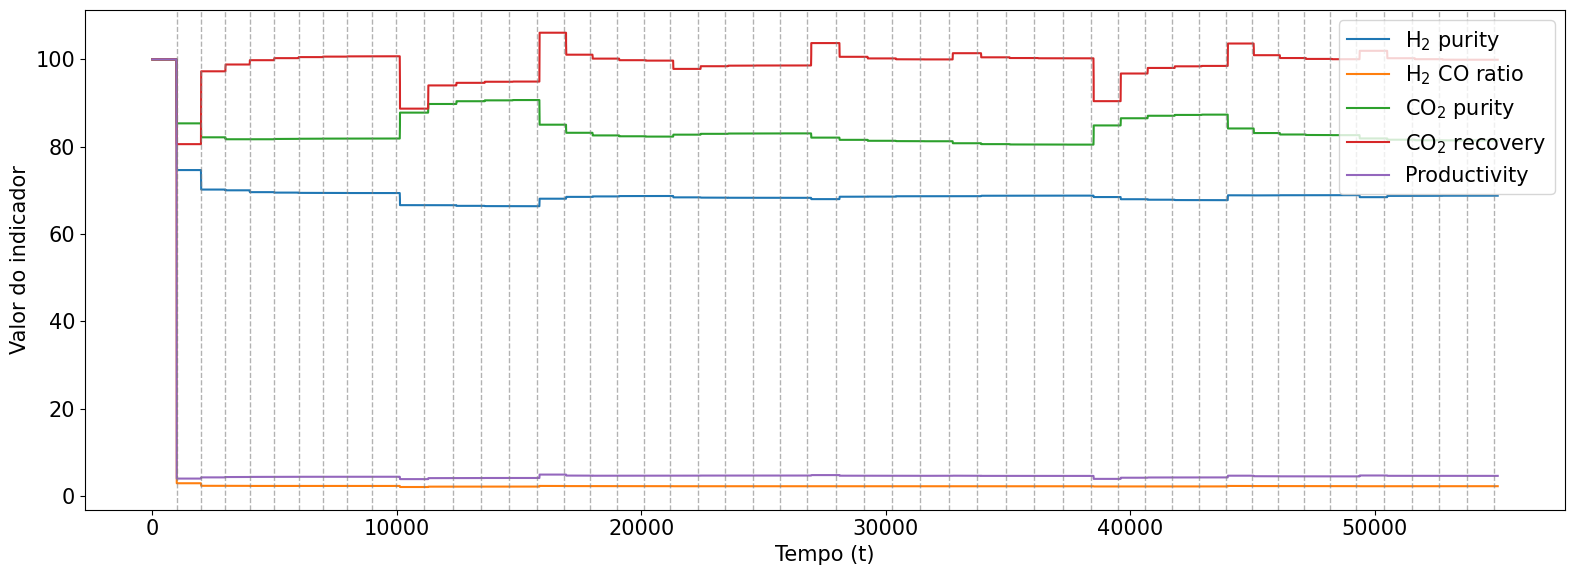

In [3]:
# @title plotando gráfico
from lib.plot import plt

plt.figure()

# Plotar todas as performances
plt.plot(t, purity_H2, label="H$_2$ purity")
plt.plot(t, H2_CO_ratio, label="H$_2$ CO ratio")
plt.plot(t, purity_CO2, label="CO$_2$ purity")
plt.plot(t, recovery_CO2, label="CO$_2$ recovery")
plt.plot(t, productivity, label="Productivity")

# Linhas verticais para cada ciclo
for tc in t_ciclo_fim:
    plt.axvline(x=tc, color="gray", linestyle="--", linewidth=1, alpha=0.6)

# Personalização do gráfico
# plt.title('Performance vs Tempo (com divisões de ciclo)')
plt.xlabel("Tempo (t)")
plt.ylabel("Valor do indicador")
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# @title Passando de segundos para ciclos

ciclos = np.arange(0, n_ciclos)

performance_por_ciclo = {}


def media_por_ciclo(t, y, t_ini, t_fim):
    """Calcula o valor médio de y dentro de cada intervalo de ciclo."""
    medias = []
    for ti, tf in zip(t_ini, t_fim):
        mask = (t >= ti) & (t < tf)
        if np.any(mask):
            medias.append(np.mean(y[mask]))
        else:
            medias.append(np.nan)
    return np.array(medias)


t_ciclo_ini = np.concatenate(([0], t_ciclo_fim[:-1]))

purity_H2_ciclo = media_por_ciclo(t, purity_H2, t_ciclo_ini, t_ciclo_fim)
H2_CO_ratio_ciclo = media_por_ciclo(t, H2_CO_ratio, t_ciclo_ini, t_ciclo_fim)
purity_CO2_ciclo = media_por_ciclo(t, purity_CO2, t_ciclo_ini, t_ciclo_fim)
recovery_CO2_ciclo = media_por_ciclo(t, recovery_CO2, t_ciclo_ini, t_ciclo_fim)
productivity_ciclo = media_por_ciclo(t, productivity, t_ciclo_ini, t_ciclo_fim)


In [5]:
# Plotando gráficos

# --- Criar subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# --- Gráfico 1: tempos de cada etapa ---
ax1.scatter(ciclos, t_feed, label="t_feed")
ax1.scatter(ciclos, t_rinse, label="t_rinse")
ax1.scatter(ciclos, t_blow, label="t_blow")
ax1.scatter(ciclos, t_purge, label="t_purge")

ax1.set_ylabel("Duração da etapa (s)")
ax1.grid(True, linestyle=":", alpha=0.5)
ax1.legend()

# --- Gráfico 2: performances por ciclo ---
ax2.scatter(ciclos, purity_H2_ciclo, label="Purity H2")
ax2.scatter(ciclos, H2_CO_ratio_ciclo, label="H2/CO ratio")
ax2.scatter(ciclos, purity_CO2_ciclo, label="Purity CO2")
ax2.scatter(ciclos, recovery_CO2_ciclo, label="Recovery CO2")
ax2.scatter(ciclos, productivity_ciclo, label="Productivity")

ax2.set_xlabel("Ciclo")
ax2.set_ylabel("Valor do Indicador")
ax2.grid(True, linestyle=":", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.savefig("../figures/KPIs-by-cycle.png")
plt.close()


In [6]:
# Deletando primeiros ciclos
del_n = 10

purity_H2_ciclo = purity_H2_ciclo[del_n:]
H2_CO_ratio_ciclo = H2_CO_ratio_ciclo[del_n:]
purity_CO2_ciclo = purity_CO2_ciclo[del_n:]
recovery_CO2_ciclo = recovery_CO2_ciclo[del_n:]
productivity_ciclo = productivity_ciclo[del_n:]

t_feed = t_feed[del_n:]
t_rinse = t_rinse[del_n:]
t_blow = t_blow[del_n:]
t_purge = t_purge[del_n:]

ciclos = ciclos[del_n:]


In [7]:
# Salvando CSV

df_resultado = pd.DataFrame(
    {
        "ciclo": ciclos,
        "t_feed": t_feed,
        "t_rinse": t_rinse,
        "t_blow": t_blow,
        "t_purge": t_purge,
        "purity_H2": purity_H2_ciclo,
        "H2_CO_ratio": H2_CO_ratio_ciclo,
        "purity_CO2": purity_CO2_ciclo,
        "recovery_CO2": recovery_CO2_ciclo,
        "productivity": productivity_ciclo,
    }
)

df_resultado.index.name = "ciclo"

df_resultado.to_csv("../export/dados.csv")
